# Deep Neural Network for Image Classification: Application

We will use use the functions you'd implemented in the previous assignment to build a deep network, and apply it to cat vs non-cat classification. There must be an improvement in accuracy

# 1. Packages

In [14]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

import numpy as np
import matplotlib.pyplot as plt
import h5py
from dnn_app_utils_v3 import *
from scipy import ndimage
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize']=(5, 4)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Dataset

You will use the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2)

In [46]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_data()

The **matrix/vector dimensions** are very important. Write out the dimensions very clearly

- **m_train** number of training images

- **m_test** number of test images

- **num_px** width and height of each image

In [47]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print('Number of training images: m_train =', m_train)
print('Number of test images: m_test =', m_test)
print('Number of width and height pixel: num_px =', num_px)
print('Size of each image:', [num_px, num_px, 3])
print('train_set_x_orig shape:', train_set_x_orig.shape)
print('train_set_y shape:', train_set_y.shape)
print('test_set_x_orig shape:', test_set_x_orig.shape)
print('test_set_y shape:', test_set_y.shape)

Number of training images: m_train = 209
Number of test images: m_test = 50
Number of width and height pixel: num_px = 64
Size of each image: [64, 64, 3]
train_set_x_orig shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x_orig shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Flatten the image** from `(m_train, num_px, num_px, 3)` to `(num_px * num_px * 3, m_train)`
![](images/imvectorkiank.png)

In [48]:
train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T

print('train_set_x_flatten shape:', train_set_x_flatten.shape)
print('train_set_y shape:', train_set_y.shape)
print('test_set_x_flatten shape:', test_set_x_flatten.shape)
print('test_set_y shape:', test_set_y.shape)

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


**Standardize the image**: get the mean and std from all pixels of all images

In [49]:
def normalize_all_pixel(flattened_dataset):
    """
    Normalize the flattened image by mean and std of all pixels in falttened_dataset
    
    Argument:
    flattened_dataset -- a 2-dimensions matrix (num_px * num_px * 3, n_images)
    
    Return:
    The matrix is normalized
    """
    mean = np.sum(flattened_dataset)/float(flattened_dataset.shape[0] * flattened_dataset.shape[1])
    std = np.sqrt(np.sum(np.square(flattened_dataset - mean)) / float(flattened_dataset.shape[0] * flattened_dataset.shape[1]))
    flattened_dataset = (flattened_dataset - mean) / float(std)
    
    return flattened_dataset

# train_set_x = normalize_all_pixel(train_set_x_flatten)
# test_set_x = normalize_all_pixel(test_set_x_flatten)
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

# 3. Architecture of L-layer
![](images/LlayerNN_kiank.png)

As usual We will follow the Deep Learning methodology to build the model:

    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    3. Use trained parameters to predict labels

## 3.1. Two layer neural network
We use 5 predefined functions in Assignment 3
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters
def activation(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(A_last, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameter(parameters, grads, learning_rate):
    ...
    return parameters
```

In [19]:
# Define layer_dims
n_x = train_set_x_flatten.shape[0]
n_h = 7
n_y = train_set_y.shape[0]
layers_dims = (n_x, n_h, n_y) # (12288, 7, 1)

In [27]:
def two_layer_model(X, Y, layers_dims, learning_rate=.0075, num_iterations=3000, print_every=500):
    """
    Implement 2 layers neural network
    
    Arguments:
    X -- input data (n_x, m)
    Y -- ground truth 0 for non-cat and 1 for cat (n_y, m)
    layers_dims -- dimensions of layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of optimization loops
    print_every -- number of iterations the cost will be printed
    
    Returns:
    parameters -- dictionary contains all weights and biases
    """
    np.random.seed(2)
    grads = {}
    costs = []
    m = X.shape[1]
    n_x, n_h, n_y = layers_dims
    
    # Initialize the parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Retrieve weights and biases from parameters
    W1, b1, W2, b2 = parameters['W1'], parameters['b1'], parameters['W2'], parameters['b2']
    
    # Loop (gradient descent)
    for i in range(num_iterations):
        # Forward propagation: Linear -> relu -> Linear -> sigmoid
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu') # cache1 includes A0 = X, W1, b1, Z1
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid') # cache1 includes A1, W2, b2, Z2
        
        # Cost
        cost = compute_cost(A2, Y)
        
        # Backward Propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1-Y, 1-A2))
        
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        grads['dW1'], grads['db1'], grads['dW2'], grads['db2'] = dW1, db1, dW2, db2
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        W1, b1, W2, b2 = parameters['W1'], parameters['b1'], parameters['W2'], parameters['b2']
        
        if print_every != None and (i+1)%print_every==0:
            costs.append(cost)
            print('Cost after', i+1, 'iterations is', cost)
            
    plt.plot(costs)
    plt.xlabel('iterations(per hundreds)')
    plt.ylabel('cost')
    plt.title('Learning rate = ' + str(learning_rate))
    
    return parameters

Cost after 100 iterations is 0.5819205430517206
Cost after 200 iterations is 0.44214758218674644
Cost after 300 iterations is 0.28343502142107163
Cost after 400 iterations is 0.15333212210009653
Cost after 500 iterations is 0.0888756888269155
Cost after 600 iterations is 0.05622486033200213
Cost after 700 iterations is 0.039160705109626326
Cost after 800 iterations is 0.029322158410554394
Cost after 900 iterations is 0.02315625599907252
Cost after 1000 iterations is 0.0190327888044579
Cost after 1100 iterations is 0.016151912418391826
Cost after 1200 iterations is 0.014047500910769157
Cost after 1300 iterations is 0.012456185418959818
Cost after 1400 iterations is 0.011229424814618345
Cost after 1500 iterations is 0.010259040057199954
Cost after 1600 iterations is 0.009470775466866428
Cost after 1700 iterations is 0.00882755130620392
Cost after 1800 iterations is 0.008293355379804149
Cost after 1900 iterations is 0.007842595276161822
Cost after 2000 iterations is 0.007458767480310691
C

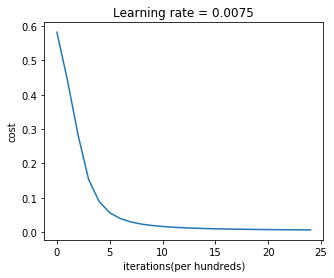

In [29]:
parameters = two_layer_model(train_set_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_every=100)

In [31]:
predictions_train = predict(train_set_x, train_set_y, parameters)
predictions_test = predict(test_set_x, test_set_y, parameters)

Accuracy: 0.9999999999999998
Accuracy: 0.78


Congratulations! It seems that 2-layer neural network has better performance (78%) than the logistic regression implementation (70%, assignment week 2)

## 3.2. L-layer neural network
We use 5 predefined functions in Assignment 3
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters
def L_layer_forward(X, parameters):
    ...
    return A_last, caches
def compute_cost(A_last, Y):
    ...
    return cost
def L_layer_backward(A_last, Y, caches):
    ...
    return grads
def update_parameter(parameters, grads, learning_rate):
    ...
    return parameters
```

In [50]:
def L_layer_model(X, Y, layers_dims, learning_rate=.0075, num_iterations=3000, print_every=500):
    """
    Implement L layers neural network
    
    Arguments:
    X -- input data (n_x, m)
    Y -- ground truth 0 for non-cat and 1 for cat (n_y, m)
    layers_dims -- dimensions of layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of optimization loops
    print_every -- number of iterations the cost will be printed
    
    Returns:
    parameters -- dictionary contains all weights and biases
    """
    np.random.seed(2)
    costs = []
    m = X.shape[1]
    
    # Initialize the parameters
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(num_iterations):
        # Forward propagation: [Linear -> relu] * (L-1) -> Linear -> sigmoid
        A_last, caches = L_model_forward(X, parameters)
        
        #Compute cost
        cost = compute_cost(A_last, Y)
        
        # Backward Propagation
        grads = L_model_backward(A_last, Y, caches)
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_every != None and (i+1)%print_every==0:
            costs.append(cost)
            print('Cost after', i+1, 'iterations is', cost)
            
    plt.plot(costs)
    plt.xlabel('iterations(per hundreds)')
    plt.ylabel('cost')
    plt.title('Learning rate = ' + str(learning_rate))
    
    return parameters

Cost after 100 iterations is 0.6723877788394318
Cost after 200 iterations is 0.6457504599239202
Cost after 300 iterations is 0.6278240987145454
Cost after 400 iterations is 0.5973174735777875
Cost after 500 iterations is 0.521548164881899
Cost after 600 iterations is 0.4831283038044845
Cost after 700 iterations is 0.4300970024825634
Cost after 800 iterations is 0.3645331374952562
Cost after 900 iterations is 0.3431782227004086
Cost after 1000 iterations is 0.29340974092684036
Cost after 1100 iterations is 0.2550264224461813
Cost after 1200 iterations is 0.22804390297234778
Cost after 1300 iterations is 0.19705590943913698
Cost after 1400 iterations is 0.18372326192685948
Cost after 1500 iterations is 0.1609978212526493
Cost after 1600 iterations is 0.14842406171000472
Cost after 1700 iterations is 0.13803169458234898
Cost after 1800 iterations is 0.12872614943352845
Cost after 1900 iterations is 0.12086572709077906
Cost after 2000 iterations is 0.11426760382035103
Cost after 2100 itera

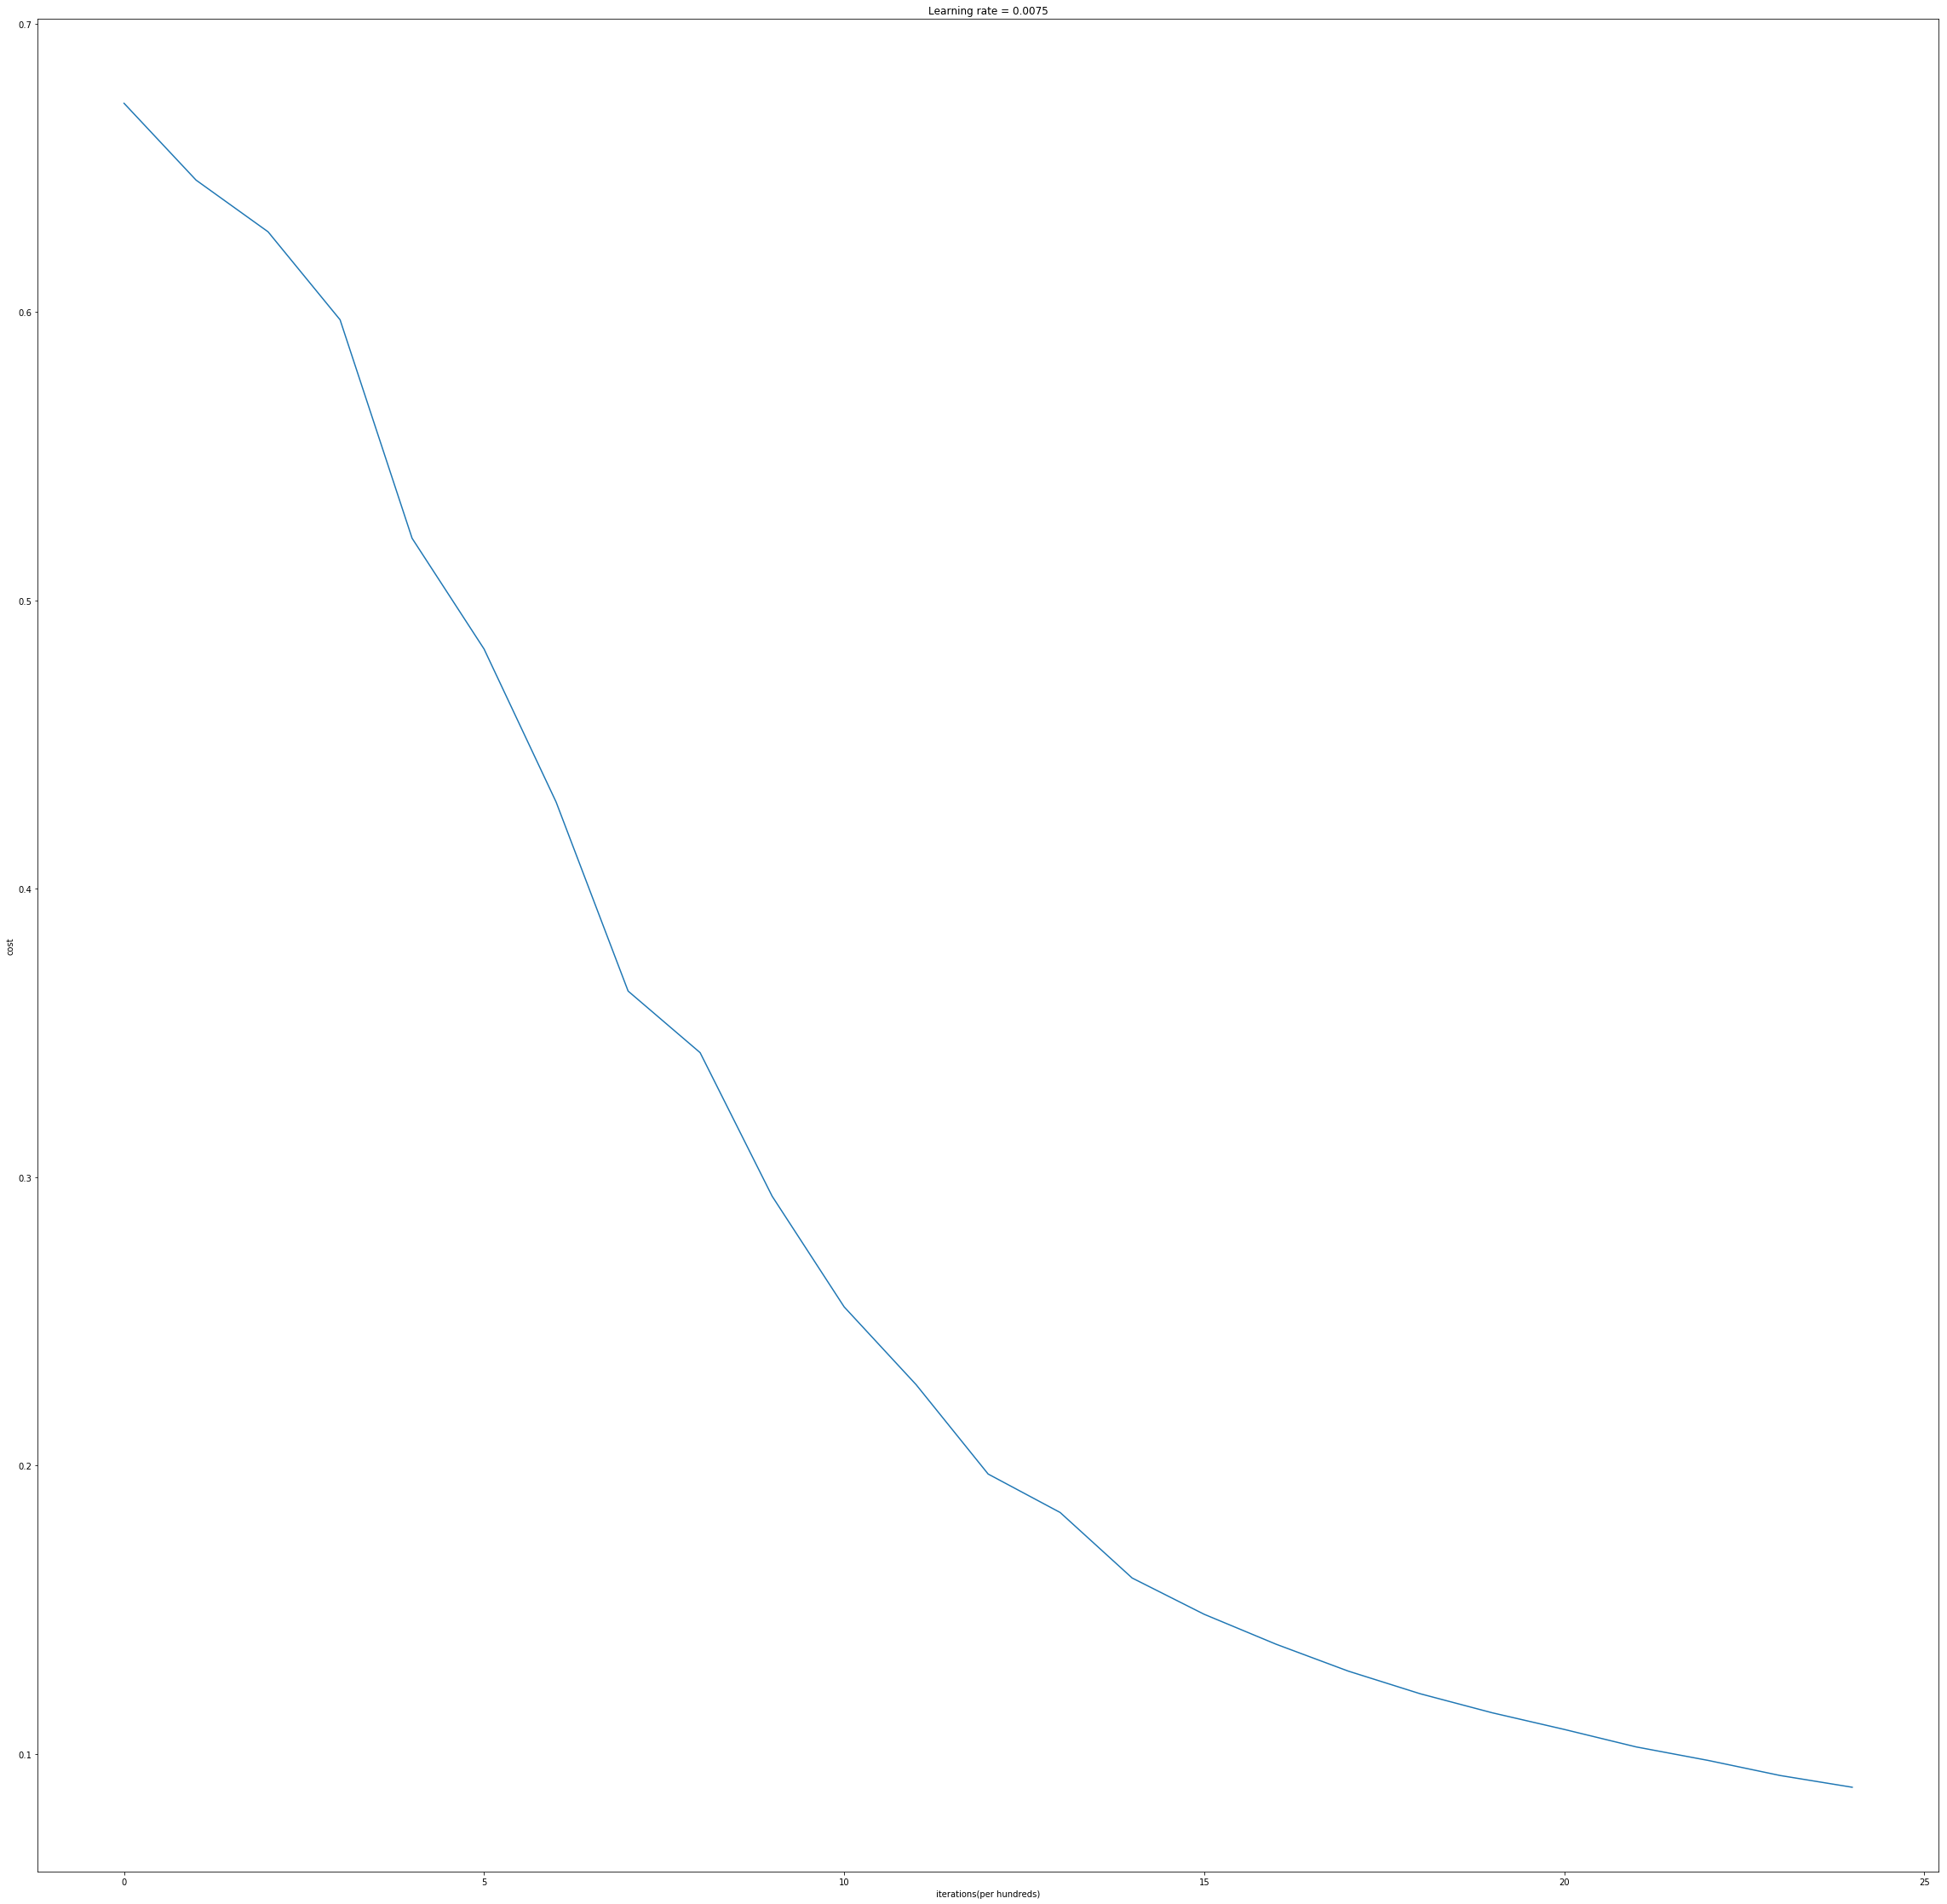

In [51]:
layers_dims = [train_set_x.shape[0], 20, 7, 5, train_set_y.shape[0]]
parameters = L_layer_model(train_set_x, train_set_y, layers_dims, num_iterations = 2500, print_every=100)

In [52]:
predictions_train = predict(train_set_x, train_set_y, parameters)
predictions_test = predict(test_set_x, test_set_y, parameters)

Accuracy: 0.9856459330143539
Accuracy: 0.8


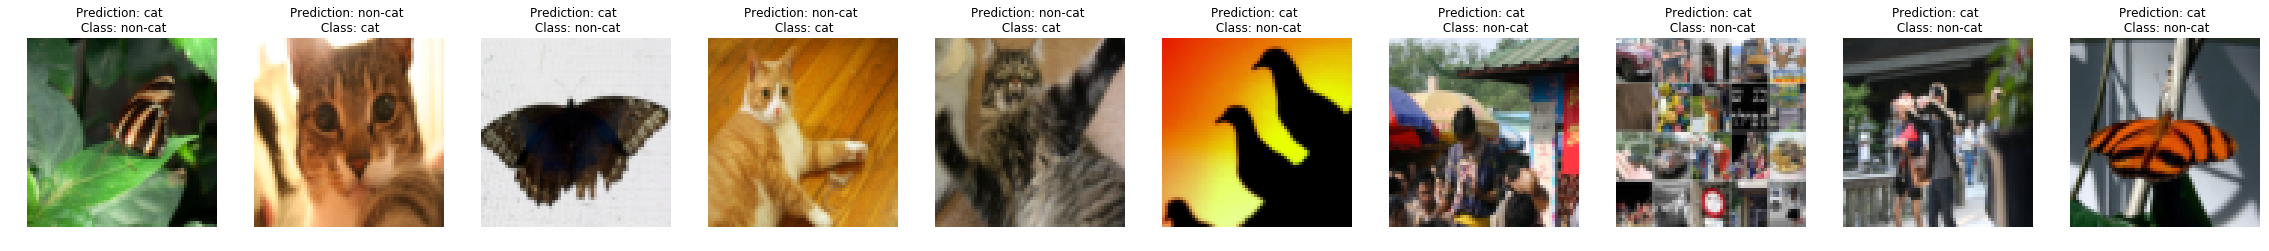

In [53]:
print_mislabeled_images(classes, test_set_x_flatten, test_set_y, predictions_test)

Congrats! It seems that your 4-layer neural network with normalize_all_pixel function has better performance (80%) than your 2-layer neural network (78%) with /255 normalize on the same test set